# SVM Classification Using Individual Replicas
This notebook analyzes the quality of the classifiers resulting from training on individual replicas of read counts rather than averaged values. Data are adjusted for library size and gene length.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Analyze Replica Data
The following shows the extent to which replicas agree with the tranary values that are assigned.

/home/ubuntu/xstate/xstate/python/common/data_provider.py:420: RuntimeWarning: divide by zero encountered in log2
  [df.applymap(lambda v: np.log2(v)) for df in


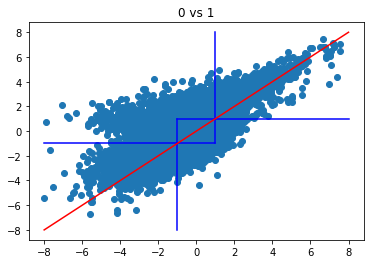

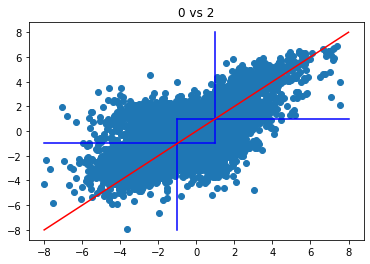

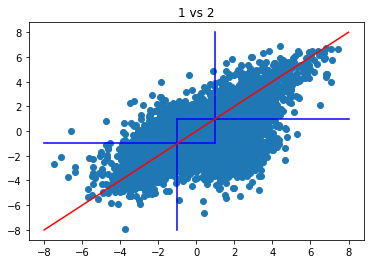

In [33]:
def compareDFValues(df1, df2, title):
    RANGE = [-8, 8]
    plt.figure()
    arr1 = df1.values.flatten()
    arr2 = df2.values.flatten()
    plt.scatter(arr1, arr2)
    # Define region of 0 values
    plt.plot([-1, -1], [-1, 1], color="b")
    plt.plot([1, 1], [-1, 1], color="b")
    plt.plot([-1, 1], [-1, -1], color="b")
    plt.plot([-1, 1], [1, 1], color="b")
    # Define region of 1 values
    plt.plot([1, 1], [1, RANGE[1]], color="b")
    plt.plot([1, RANGE[1]], [1, 1], color="b")
    # Define region of -1 values
    plt.plot([-1, -1], [-1, RANGE[0]], color="b")
    plt.plot([-1, RANGE[0]], [-1, -1], color="b")
    plt.plot(RANGE, RANGE, color="r")
    plt.title(title)
    
provider = DataProvider()
provider.do()
dfs = []
for idx in range(3):
      dfs.append(provider.dfs_adjusted_read_count_wrtT0_log2[idx])
compareDFValues(dfs[0], dfs[1], "0 vs 1")
compareDFValues(dfs[0], dfs[2], "0 vs 2")
compareDFValues(dfs[1], dfs[2], "1 vs 2")
    

In [13]:
dfs[0].values.flatten()


array([ 0.        ,  0.10046526,  0.38050473, ...,  0.03536785,
       -1.08206371, -0.74372999])

## SVM With Replicas

In [2]:
provider = DataProvider(is_normalized_wrtT0=True)
provider.do()
for n in range(3):
    print(provider.dfs_adjusted_read_count_wrtT0[n].head())

         T0.0      T1.0      T2.0      T3.0      T4.0      T5.0      T6.0  \
Rv0001    1.0  1.072119  1.301797  1.255190  1.353351  1.274508  0.919210   
Rv0005    1.0  1.637825  1.730923  2.040822  1.984227  1.989241  1.762261   
Rv0006    1.0  1.628194  1.519583  1.936701  1.928850  1.580781  1.886713   
Rv0009    1.0  1.959713  2.390467  1.762375  2.045719  2.008867  1.793311   
Rv0010c   1.0  1.378715  1.160466  1.171577  1.136251  1.267012  1.108681   

             T7.0      T8.0      T9.0  ...     T16.0     T17.0     T18.0  \
Rv0001   1.035712  0.886113  0.764993  ...  1.563982  1.154330  1.396935   
Rv0005   1.936669  0.991634  1.737733  ...  1.529332  0.867944  1.185441   
Rv0006   1.941937  0.752407  1.766990  ...  1.124146  0.692071  1.033188   
Rv0009   1.764238  0.707191  1.642490  ...  0.877297  0.545770  0.691607   
Rv0010c  1.048403  0.656563  0.844574  ...  0.672185  0.488660  0.488790   

            T19.0     T20.0     T21.0     T22.0     T23.0     T24.0     T25.0  


In [36]:
trinary = TrinaryData(is_averaged=False)
trinary.df_X.head()
df_X = trinary.df_X.copy()
df_X.columns = trinary.features
ser_y = trinary.ser_y

In [38]:
ser_y

T1.0     0
T2.0     1
T3.0     1
T4.0     1
T5.0     1
        ..
T21.2    2
T22.2    0
T23.2    0
T24.2    0
T25.2    0
Name: name, Length: 75, dtype: int64

In [ ]:
# Construct a classifier using each replica
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
    classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=filter, size=30)
svm_ensemble.fit(trinary.df_X, trinary.ser_y)
# Analysis to determine how many features should be considered
svm_ensemble.plotImportance(title="%d" % filter, ylim=[0, 1.5], ylabel="Parameter Value")
#svm_ensemble.plotRank()